# BERT for emotion detection

## Files

In [0]:
LOAD_FROM_LOCAL = True

BASE_URL   = 'https://lthelsinkioffens.slack.com/files/UTPAU0RGF/F015V2CCFPA/'
TRAIN_PATH = 'adx.train'
DEV_PATH   = 'adx.dev'
TEST_PATH  = 'adx.test'

if LOAD_FROM_LOCAL:
  from google.colab import files
  uploaded = files.upload()

## Settings

In [0]:
#@title Hyperparameters

SEED = 12345 #@param {type:"raw"}

BERT_MODEL = 'english_base_uncased' #@param ["multilingual", "english_base_cased", "english_large_cased", "english_base_uncased", "english_large_uncased", "finnish_cased", "finnish_uncased", "dutch", "chinese", "german", "arabic", "greek", "turkish"]
#DO_PREPROCESSING = False #@param {type:"boolean"}
#DO_BALANCING = False #@param {type:"boolean"}

EPOCHS = 3 #@param ["2", "3", "4"] {type:"raw"}
MAX_LEN =  48  #@param ["32", "48", "64", "128", "256", "512"] {type:"raw"}
BATCH_SIZE = 96 #@param ["128", "96", "64", "32", "16", "8"] {type:"raw"}
LEARN_RATE = 2e-5 #@param ["3e-4", "1e-4", "5e-5", "3e-5", "2e-5"] {type:"raw"}
EPSILON = 1e-8 #@param ["1e-6", "1e-7", "1e-8"] {type:"raw"}
nb_warmup_steps = 0 #@param {type:"raw"}

#@markdown ---
CROSS_VALIDATION = False #@param {type:"boolean"}
NUM_FOLDS  = 5 #@param ["3", "5", "10"] {type:"raw"}

CHANGE_SPLIT = True #@param {type:"boolean"}
PCTG_TRAIN = 0.75 #@param {type:"slider", min:0, max:1, step:0.05}
PCTG_DEV   = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}
PCTG_TEST  = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}


## Installs

In [0]:
%%capture
!pip install transformers

## Imports

In [0]:
import sys, io, os, re, csv, json, string, time, datetime, random, unicodedata, itertools, collections, torch
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.utils import resample

% matplotlib inline
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
pd.set_option('precision', 4)

## Dictionaries

In [0]:
models = {
    "english_base_cased": ('bert-base-cased',False),
    "english_large_cased": ('bert-large-cased',False),
    "english_base_uncased": ('bert-base-uncased',True),
    "english_large_uncased": ('bert-large-uncased',True),
    "multilingual": ('bert-base-multilingual-cased',False),
    "finnish_cased": ('TurkuNLP/bert-base-finnish-cased-v1',False),
    "finnish_uncased": ('TurkuNLP/bert-base-finnish-uncased-v1',True),
    "dutch": ('wietsedv/bert-base-dutch-cased',False),
    "chinese": ('bert-base-chinese',False),
    "german": ('bert-base-german-cased',False),
    "arabic": ('asafaya/bert-base-arabic',False),
    "greek": ('nlpaueb/bert-base-greek-uncased-v1',True),
    "turkish": ('dbmdz/bert-base-turkish-cased',False)
}

datasets_olid = {
    "arabic": "https://github.com/mapama247/TFM/raw/master/ar20a.tsv",
    "danish":  "https://github.com/mapama247/TFM/raw/master/da20a.tsv",
    "english": "https://github.com/mapama247/TFM/raw/master/en19a.tsv",
    "greek":   "https://github.com/mapama247/TFM/raw/master/gr20a.tsv",
    "turkish": "https://github.com/mapama247/TFM/raw/master/tr20a.tsv"
}

## Environment setup

In [0]:
if tf.test.gpu_device_name() == '/device:GPU:0':
    print('Found GPU at: {}'.format(tf.test.gpu_device_name()))
else:
    raise SystemError('GPU device not found')

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Using', torch.cuda.get_device_name(0), ':)')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
Using Tesla T4 :)


## Aux functions

### Formatting data

In [0]:
def prepare_data(sentences, labels, random_sampling=False):
  input_ids=[]
  attention_masks = []
  for sentence in sentences:
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_LEN, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
  
  # Convert numpy arrays to pytorch tensors
  inputs = torch.cat(input_ids, dim=0)
  masks =  torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Create the DataLoader for the given set (iterator to save memory)
  data = TensorDataset(inputs, masks, labels)
  if random_sampling: # train data
      sampler = RandomSampler(data)
  else: # dev and test data
      sampler = SequentialSampler(data)
  dataloader = DataLoader(data, sampler=sampler, batch_size=BATCH_SIZE)
  
  return dataloader

### Train model

In [0]:
def train(model, optimizer, scheduler, train_dataloader, dev_dataloader, epochs, verbose=True):
  total_t0 = time.time() # Measure the total training time for the whole run.

  training_stats = [] # training loss, validation loss, validation accuracy and timings.

  for epoch_i in range(0, epochs):
      if verbose: print('\n======== Epoch {:} / {:} ========'.format(epoch_i+1, epochs))
      else: print("Epoch",epoch_i+1,"of",epochs,"...")
      
      t0 = time.time()     # Measure how long the training epoch takes.
      total_train_loss = 0 # Reset the total loss for this epoch.
      model.train()        # Put the model into training mode.

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):
          
          if verbose==True and step%40==0 and not step==0: # Progress update every 40 batches.
              elapsed = format_time(time.time()-t0) # Calculate elapsed time in minutes.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader and copy each tensor to the GPU using the to() method.
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a backward pass.
          model.zero_grad()

          # Perform a forward pass (evaluate the model on this training batch).
          loss, logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

          # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0 in order to prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step() # Update parameters and take a step using the computed gradient.
          scheduler.step() # Update the learning rate.

      avg_train_loss = total_train_loss / len(train_dataloader) # Calculate the average loss over the training data.
      if verbose: print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)
      if verbose: print("  Training epcoh took: {:}".format(training_time))

      ########## VALIDATION ##########
      t0 = time.time()
      model.eval() # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
      eval_loss, eval_accuracy, nb_eval_examples = 0, 0, 0      # Tracking variables 

      # Tracking variables 
      total_eval_accuracy, total_eval_loss, nb_eval_steps = 0, 0, 0

      # Evaluate data for one epoch
      for batch in dev_dataloader:
          # Unpack the inputs from the dataloader object after adding batch to GPU
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Telling the model not to compute or store gradients, saving memory and speeding up validation
          with torch.no_grad():        
              # Forward pass, calculate logit predictions (output values prior to applying an activation function)
              (loss, logits) = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

          logits = logits.detach().cpu().numpy() # Move logits to CPU
          label_ids = b_labels.to('cpu').numpy() # Move labels to CPU

          total_eval_loss += loss.item() # Accumulate the validation loss.
          total_eval_accuracy += flat_accuracy(logits, label_ids) # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.

          nb_eval_steps += 1 # Track the number of batches

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
      if verbose: print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Report the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(dev_dataloader)
      if verbose: print("  Validation Loss: {0:.2f}".format(avg_val_loss))

      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      if verbose: print("  Validation took: {:}".format(validation_time))  

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Train Loss': avg_train_loss,
              'Valid Loss': avg_val_loss,
              'Valid Acc': avg_val_accuracy,
              'Train Time': training_time,
              'Valid Time': validation_time
          }
      )

  print("\nTraining complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  df_stats = pd.DataFrame(data=training_stats)
  df_stats = df_stats.set_index('epoch')
  return df_stats

### Make predictions

In [0]:
def predict(model, dataloader):
  print('Predicting labels for test sentences...')

  model.eval() # Put model in evaluation mode

  predictions = [] # Tracking variable
  true_labels = [] # Tracking variable

  for batch in dataloader:
    batch = tuple(t.to(device) for t in batch) # Add batch to GPU
    
    b_input_ids, b_input_mask, b_labels = batch # Unpack the inputs from the dataloader
    
    with torch.no_grad(): # do not compute or store gradients to save memory and speed up prediction
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask) # Forward pass, calculate logit predictions
    
    logits = outputs[0] # retrieve the model outputs prior to activation
    logits = logits.detach().cpu().numpy() # Move logits to CPU
    label_ids = b_labels.to('cpu').numpy() # Move labels to CPU
    
    predictions.append(logits)    # Store predictions
    true_labels.append(label_ids) # Store true labels

  print('COMPLETED.\n')
  return predictions, true_labels

### Evaluate model

In [0]:
def evaluate(predictions, true_labels, avg='macro', verbose=True):
  avgs = ['micro', 'macro', 'weighted', 'samples']
  if avg not in avgs:
    raise ValueError("Invalid average type (avg). Expected one of: %s" % avgs)

  # Combine the predictions for each batch into a single list.
  flat_predictions = [item for sublist in predictions for item in sublist]
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = [item for sublist in true_labels for item in sublist]

  # Compute the results.
  precision = precision_score(flat_true_labels, flat_predictions, average=avg)
  recall    = recall_score(flat_true_labels, flat_predictions, average=avg)
  f1        = f1_score(flat_true_labels, flat_predictions, average=avg)
  acc       = accuracy_score(flat_true_labels,flat_predictions)

  # Report the results.
  if verbose:
    print('Accuracy:        %.4f' % acc)
    print(avg+' Precision: %.4f' % f1)
    print(avg+' Recall:    %.4f' % f1)
    print(avg+' F1 score:  %.4f' % f1, "\n")
    print(confusion_matrix(flat_true_labels,flat_predictions))
    #print(classification_report(flat_true_labels, flat_predictions, digits=2, zero_division='warn'))

  return f1, acc

### Plots

In [0]:
def plot_lengths_distribution(lengths, title="Length distribution of tokenized sentences"):
  sns.set(style="darkgrid")
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"]=(10,5)
  lengths = [min(length,MAX_LEN) for length in lengths]
  ax = sns.distplot(lengths,kde=False,rug=False, hist_kws={"rwidth":5,'edgecolor':'black', 'alpha':1.0}) 
  plt.title("Sequence length distribution")
  plt.xlabel("Sequence Length")
  plt.ylabel("Counts")

  num_truncated = lengths.count(MAX_LEN)
  num_sentences = len(lengths)
  print("{:.1%} of the training examples ({:,} of them) have more than {:,} tokens".format(float(num_truncated)/float(num_sentences),num_truncated,MAX_LEN))

def plot_value_counts(df, title="Label distribution"):
  emotions = ['TRUST','ANGRY','ANTICIP.','DISGUST','FEAR','JOY','SADNESS','SURPRISE']
  df2 = df.replace([0,1,2,3,4,5,6,7], emotions)
  df2.label.value_counts(normalize=False).sort_index().plot(kind='bar')
  plt.xticks(rotation=25)
  plt.title(title)
  plt.show()

def plot_loss(df_stats, plot_train=True, plot_valid=True):
  sns.set(style='darkgrid') # Use plot styling from seaborn.
  sns.set(font_scale=1.5) # Increase the plot size.
  plt.rcParams["figure.figsize"] = (12,6) # Increase the font size.
  if plot_train: plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
  if plot_valid: plt.plot(df_stats['Valid Loss'], 'g-o', label="Validation")
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4])
  plt.show()

### Aux

In [0]:
def flat_accuracy(preds, labels):
    """Function to calculate the accuracy of our predictions vs labels"""
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    """Function for formatting elapsed times: Takes a time in seconds and returns a string hh:mm:ss"""
    elapsed_rounded = int(round((elapsed))) # Round to the nearest second.
    return str(datetime.timedelta(seconds=elapsed_rounded)) # Format as hh:mm:ss

def print_model_params(my_model):
  """Function to print all the model's parameters as a list of tuples: (name,dimensions)"""
  params = list(my_model.named_parameters())
  print('The BERT model has {:} different named parameters.\n'.format(len(params)))
  print('==== Embedding Layer ====\n')
  for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
  print('\n==== First Transformer ====\n')
  for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
  print('\n==== Output Layer ====\n')
  for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

## Read data

The entire dataset was split using 0.75 for training, 0.15 for validation and 0.1 for testing.

Number of sentences train set: 18,123
Number of sentences dev set:   3,624
Number of sentences test set:  2,417


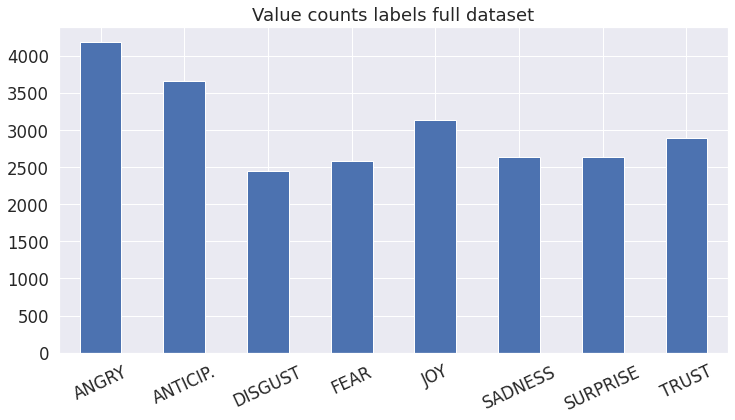

In [0]:
df_train = pd.read_csv("adx_train.txt", delimiter='\t', header=None, names=['label','sentence']).sample(frac=1, random_state=SEED)
df_dev = pd.read_csv("adx_dev.txt"  , delimiter='\t', header=None, names=['label','sentence']).sample(frac=1, random_state=SEED)
df_test  = pd.read_csv("adx_test.txt" , delimiter='\t', header=None, names=['label','sentence']).sample(frac=1, random_state=SEED)

df_train["label"].replace({8: 0}, inplace=True)
df_dev["label"].replace({8: 0}, inplace=True)
df_test["label"].replace({8: 0}, inplace=True)

df_data = pd.concat([df_train, df_dev, df_test]).sample(frac=1, random_state=SEED)
NUM_CLASSES = len(df_data.groupby('label'))

if CHANGE_SPLIT:
  if PCTG_TRAIN+PCTG_DEV+PCTG_TEST!=1:
    raise SystemError('Check train-dev-test percentages! The sum of them should be 1.')
  else:
    print('The entire dataset was split using',PCTG_TRAIN,'for training,',PCTG_DEV,'for validation and',PCTG_TEST,'for testing.\n')
    df_train, df_dev, df_test = np.split(df_data, [int(PCTG_TRAIN*len(df_data)), int((1-PCTG_TEST)*len(df_data))])
else:
  print('The original train-dev-test sets are used.\n')

X_train = df_train.sentence.values
y_train = df_train.label.values
X_dev = df_dev.sentence.values
y_dev = df_dev.label.values
X_test = df_test.sentence.values
y_test = df_test.label.values

print('Number of sentences train set: {:,}'.format(len(X_train)))
print('Number of sentences dev set:   {:,}'.format(len(X_dev)))
print('Number of sentences test set:  {:,}'.format(len(X_test)))

plot_value_counts(df_data, title="Value counts labels full dataset")
#plot_value_counts(df_train, title="Value counts labels train set")
#plot_value_counts(df_dev, title="Value counts labels dev set")
#plot_value_counts(df_test, title="Value counts labels test set")

## Load model

In [0]:
model = BertForSequenceClassification.from_pretrained(bert_model, num_labels=NUM_CLASSES, output_attentions=False, output_hidden_states=False)
model.cuda() # Tell pytorch to run this model on the GPU.

print_model_params(model)

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Load built-in tokenizer

In [0]:
bert_model = models[BERT_MODEL][0]
lowercase = models[BERT_MODEL][1]

tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=lowercase)
print('Text will be split into tokens using the', bert_model,'built-in tokenizer.\n')

print("Hello I am a MONKEY \U0001F648")
print(tokenizer.tokenize("Hello I am a monkey \U0001F648"))

Text will be split into tokens using the bert-base-uncased built-in tokenizer.

Hello I am a MONKEY 🙈
['hello', 'i', 'am', 'a', 'monkey', '[UNK]']


## Analysis of tokenized sentences length

0.1% of the training examples (11 of them) have more than 48 tokens
Increase MAX_LEN if too many truncated sentences, decrease it if too much padding.


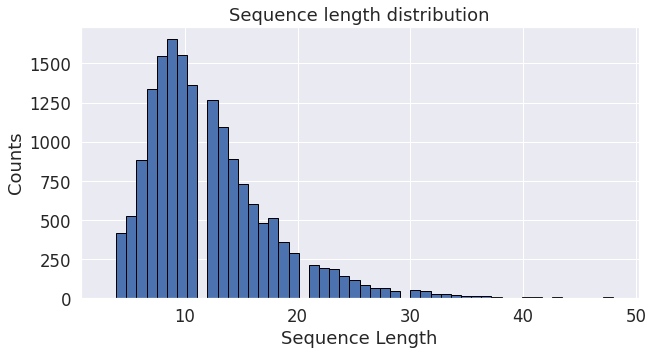

In [0]:
lengths = []
for sent in X_train:
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  l = min(MAX_LEN, len(input_ids))
  lengths.append(l)

plot_lengths_distribution(lengths, title="Length distribution of tokenized train sentences")
print('Increase MAX_LEN if too many truncated sentences, decrease it if too much padding.')

## Formatting data

In [0]:
train_dataloader      = prepare_data(X_train, y_train, True)
dev_dataloader        = prepare_data(X_dev, y_dev, False)
prediction_dataloader = prepare_data(X_test, y_test, False)

## Main

In [0]:
adam         = AdamW(model.parameters(), lr=LEARN_RATE, eps=EPSILON)
total_steps  = len(train_dataloader) * EPOCHS # Total number of training steps is nb_batches times nb_epochs.
linear_sch   = get_linear_schedule_with_warmup(adam, num_warmup_steps=nb_warmup_steps, num_training_steps=total_steps)

training_stats = train(model=model, optimizer=adam, scheduler=linear_sch, train_dataloader, dev_dataloader, EPOCHS, verbose=True)


======== Epoch 1 / 3 ========
  Batch    40  of    177.    Elapsed: 0:00:30.
  Batch    80  of    177.    Elapsed: 0:00:58.
  Batch   120  of    177.    Elapsed: 0:01:27.
  Batch   160  of    177.    Elapsed: 0:01:56.

  Average training loss: 1.76
  Training epcoh took: 0:02:08
  Accuracy: 0.44
  Validation Loss: 1.54
  Validation took: 0:00:13

======== Epoch 2 / 3 ========
  Batch    40  of    177.    Elapsed: 0:00:29.
  Batch    80  of    177.    Elapsed: 0:00:58.
  Batch   120  of    177.    Elapsed: 0:01:26.
  Batch   160  of    177.    Elapsed: 0:01:55.

  Average training loss: 1.44
  Training epcoh took: 0:02:07
  Accuracy: 0.47
  Validation Loss: 1.49
  Validation took: 0:00:13

======== Epoch 3 / 3 ========
  Batch    40  of    177.    Elapsed: 0:00:29.
  Batch    80  of    177.    Elapsed: 0:00:58.
  Batch   120  of    177.    Elapsed: 0:01:26.
  Batch   160  of    177.    Elapsed: 0:01:55.

  Average training loss: 1.32
  Training epcoh took: 0:02:07
  Accuracy: 0.46
  Va

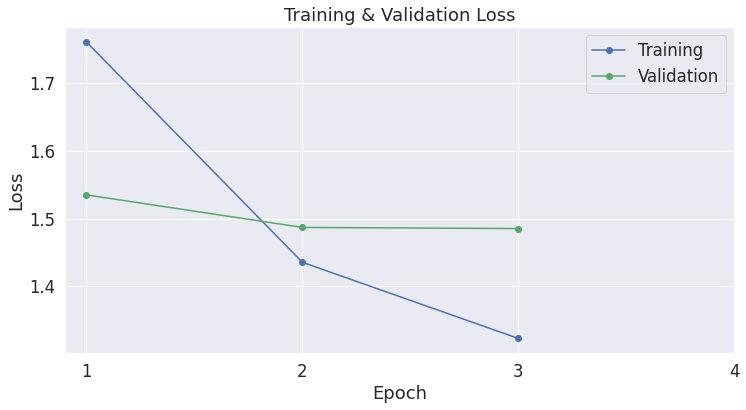

,Train Loss,Valid Loss,Valid Acc,Train Time,Valid Time
epoch,,,,,
1,1.7613,1.5350,0.4400,0:02:08,0:00:13
2,1.4353,1.4869,0.4659,0:02:07,0:00:13
3,1.3226,1.4852,0.4644,0:02:07,0:00:13


In [0]:
plot_loss(training_stats)
training_stats

In [0]:
predictions, true_labels = predict(model, prediction_dataloader)
f1, acc = evaluate(predictions, true_labels, avg='macro')

Predicting labels for test sentences...
COMPLETED.

Accuracy:        0.4733
macro Precision: 0.4637
macro Recall:    0.4637
macro F1 score:  0.4637 

[[118  26  62   4  14  46  12   7]
 [ 16 221  35  33  36   7  28  42]
 [ 40  35 187   5  27  30   8  34]
 [  6  93   5  66  15   6  34  19]
 [ 19  31  19   8 107   4  45  25]
 [ 39   7  48   3   4 180  20  13]
 [ 11  32  11  10  29   5 145  20]
 [ 10  35  26   4  24  20  25 119]]


## Cross-Validation

In [0]:
# if 5 folds:  20% for testing (1 fold), 70.00% for training and 10.00% for validation
# if 10 folds: 10% for testing (1 fold), 78.75% for training and 11.25% for validation

if CROSS_VALIDATION:
  kf = KFold(n_splits=NUM_FOLDS, random_state=SEED, shuffle=True)

  mf1s = []
  accs = []
  fold_num = 1
  for train_index, test_index in kf.split(df_data):
      print("##### Fold number:", fold_num, "#####")
      fold_num += 1
      train_df = df_data.iloc[train_index]
      test_df  = df_data.iloc[test_index]

      train_df, dev_df = train_test_split(train_df, test_size=0.125) # change percentage (hyperparams?)

      X_train, y_train = train_df.sentence.values, train_df.label.values
      X_dev, y_dev = dev_df.sentence.values, dev_df.label.values
      X_test, y_test = test_df.sentence.values, test_df.label.values
      
      train_dataloader      = prepare_data(X_train, y_train, 1)
      dev_dataloader        = prepare_data(X_dev, y_dev, 0)
      prediction_dataloader = prepare_data(X_test, y_test, 0)

      training_stats = train(model, train_dataloader, dev_dataloader, epochs=EPOCHS, verbose=False)
      predictions, true_labels = predict(model, prediction_dataloader)
      mf1, acc = evaluate(predictions, true_labels, verbose=False)
      mf1s.append(mf1)
      accs.append(acc)
  
  print("#####################################################################")
  print("PARAMS: epochs:",EPOCHS,", lr_rate:",LEARN_RATE,"epsilon:",EPSILON,"...")
  print("#####################################################################")
  print("F1(CV):",mf1s)
  print(f"Mean-folds-F1: {sum(mf1s)/len(mf1s)}")
  print("Acc(CV):",accs)
  print(f"Mean-folds-Acc: {sum(accs)/len(accs)}")

##### Fold number: 1 #####
Epoch 1 of 3 ...
Epoch 2 of 3 ...
Epoch 3 of 3 ...

Training complete!
Total training took 0:06:40 (h:mm:ss)
Predicting labels for test sentences...
COMPLETED.

##### Fold number: 2 #####
Epoch 1 of 3 ...
Epoch 2 of 3 ...
Epoch 3 of 3 ...

Training complete!
Total training took 0:06:40 (h:mm:ss)
Predicting labels for test sentences...
COMPLETED.

##### Fold number: 3 #####
Epoch 1 of 3 ...
Epoch 2 of 3 ...
Epoch 3 of 3 ...

Training complete!
Total training took 0:06:40 (h:mm:ss)
Predicting labels for test sentences...
COMPLETED.

##### Fold number: 4 #####
Epoch 1 of 3 ...
Epoch 2 of 3 ...
Epoch 3 of 3 ...

Training complete!
Total training took 0:06:40 (h:mm:ss)
Predicting labels for test sentences...
COMPLETED.

##### Fold number: 5 #####
Epoch 1 of 3 ...
Epoch 2 of 3 ...
Epoch 3 of 3 ...

Training complete!
Total training took 0:06:40 (h:mm:ss)
Predicting labels for test sentences...
COMPLETED.

#######################################
F1(CV): [0.524800524